In [40]:
from datasets import load_dataset
from transformers import AutoTokenizer, MBart50TokenizerFast
from transformers import MarianMTModel, MBartForConditionalGeneration, T5ForConditionalGeneration
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import evaluate
import csv
import re

### Get Pretrained Model Score ###

In [ ]:
raw_datasets = load_dataset("Helsinki-NLP/opus-100", "en-id")
raw_datasets

In [ ]:
model_type = "muvazana/flan-t5-base-opus-en-id-id-en"

if model_type == "Helsinki-NLP/opus-mt-en-mul":  
    tokenizer = AutoTokenizer.from_pretrained(model_type, use_fast=False)
elif model_type == "facebook/mbart-large-50-one-to-many-mmt":
    tokenizer = MBart50TokenizerFast.from_pretrained(model_type, src_lang="en_XX", tgt_lang="id_ID")
elif model_type == "muvazana/flan-t5-base-opus-en-id-id-en":
    tokenizer = AutoTokenizer.from_pretrained(model_type)

In [ ]:
if model_type == "Helsinki-NLP/opus-mt-en-mul":  
    model = MarianMTModel.from_pretrained(model_type)
elif model_type == "facebook/mbart-large-50-one-to-many-mmt":
    model = MBartForConditionalGeneration.from_pretrained(model_type)
elif model_type == "muvazana/flan-t5-base-opus-en-id-id-en":
    model = T5ForConditionalGeneration.from_pretrained(model_type)

model = model.cuda()

In [ ]:
def normalize_text(text):
    text = text.lower()  # Lowercase
    return text

test_dataset_english = []
test_dataset_indonesia = []

if model_type == "Helsinki-NLP/opus-mt-en-mul":  
    prefix = ">>ind<< "
elif model_type == "facebook/mbart-large-50-one-to-many-mmt":
    prefix = ""
elif model_type == "muvazana/flan-t5-base-opus-en-id-id-en":
    prefix = "translate to Indonesia: "
    
for i in raw_datasets['validation']['translation']:
    test_dataset_english.append(prefix + normalize_text(i['en']))
    test_dataset_indonesia.append(normalize_text(i['id']))

In [ ]:
from evaluate import load

def generate_translation(model, tokenizer, english_texts):
  """
  Generates translations for a list of English strings using the provided model and tokenizer.

  Args:
      model: The pre-trained translation model.
      tokenizer: The tokenizer associated with the model.
      english_texts: A list of English strings for translation.
      device: The device to use for computation ("cpu" or "cuda" if available). Defaults to "cuda" if available.

  Returns:
      A list of translated texts and a dictionary containing BLEU and METEOR scores.
  """

  # Optional: Preprocess English text (e.g., lowercase)
  # english_texts = [text.lower() for text in english_texts]

  translated_texts = []
  for i in range(0, len(english_texts), 16):  # Process in batches of 16
    batch_english_texts = english_texts[i:i+16]  # Get a batch of English sentences

    # Tokenize the batch
    tokenized_english = tokenizer(batch_english_texts, return_tensors="pt", padding=True, truncation=True, max_length=500).to("cuda")

    # Generate translations
    if model_type == "facebook/mbart-large-50-one-to-many-mmt":
      translated = model.generate(**tokenized_english, forced_bos_token_id=tokenizer.lang_code_to_id["id_ID"])
      translated_texts.extend(tokenizer.batch_decode(translated, skip_special_tokens=True))

    elif model_type == "Helsinki-NLP/opus-mt-en-mul": 
      translated = model.generate(**tokenized_english)
      translated_texts.extend(tokenizer.batch_decode(translated, skip_special_tokens=True))

    elif model_type == "muvazana/flan-t5-base-opus-en-id-id-en": 
      translated = model.generate(**tokenized_english, max_new_tokens=512)
      translated_texts.extend(tokenizer.batch_decode(translated, skip_special_tokens=True))

  # Compute BLEU and METEOR scores (using evaluate library)
  metric = load("sacrebleu")
  meteor = load('meteor')
  references = [ref for ref in test_dataset_indonesia]  # Assuming a list of Indonesian references
  predictions = [text for text in translated_texts]
  results = metric.compute(predictions=predictions, references=references)
  meteor_result = meteor.compute(predictions=predictions, references=references)

  return predictions, results, meteor_result, references

# Generate translations and compute scores
translated_texts, bleu_scores, meteor_result, references = generate_translation(model, tokenizer, test_dataset_english)

In [ ]:
sample_num = 1000
print(f"Sample English Text: {test_dataset_english[sample_num]}")
print(f"Translated Indonesian: {translated_texts[sample_num]}")  
print(f"References Indonesian: {references[sample_num]}")
print(f"BLEU Score: {bleu_scores['score']}")
print(f"METEOR Score: {meteor_result['meteor']}")

MarianMT<br>
BLEU Score: 24.956694956159293<br>
METEOR Score: 0.5063619252134666<br><br>

mBART<br>
BLEU Score: 18.35324617445085<br>
METEOR Score: 0.4694517485331393<br><br>

T5<br>
BLEU Score: 20.516568490719592<br>
METEOR Score: 0.517895458626222<br><br>

### Make Plot ###

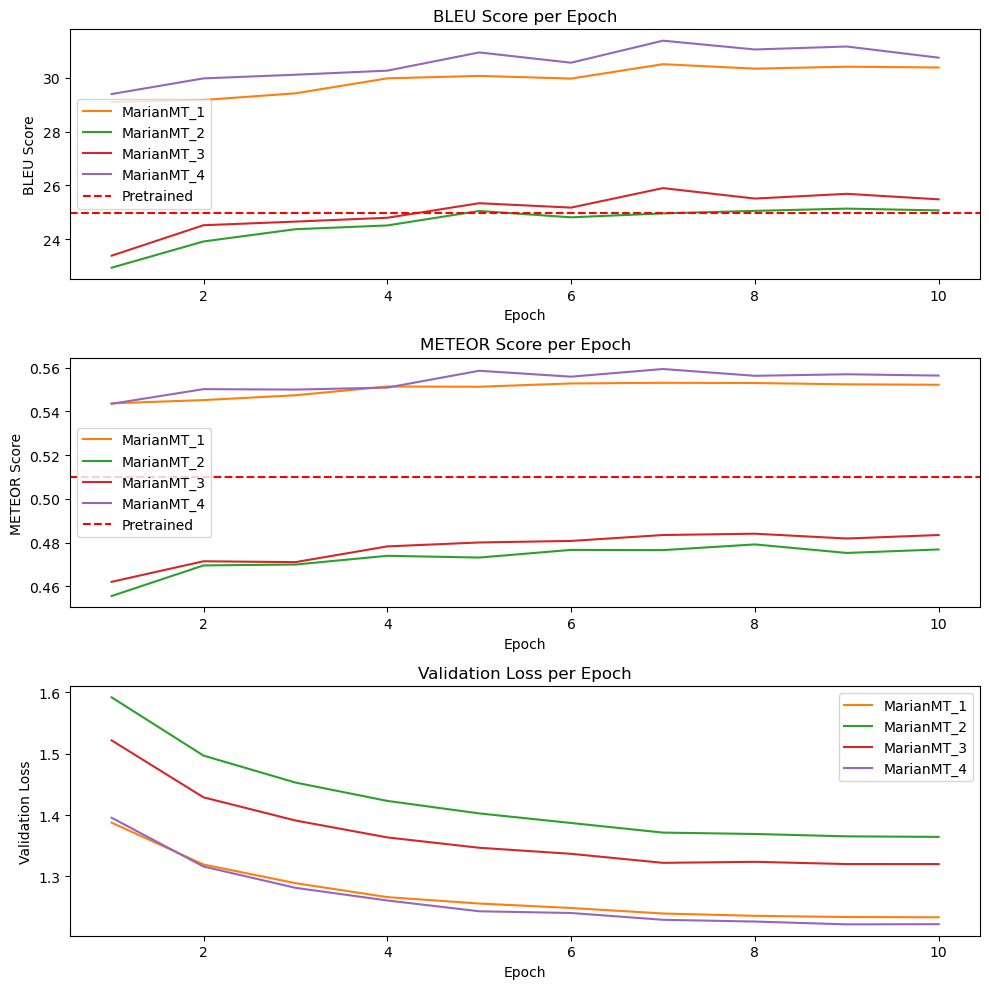

In [78]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
model_name = "MarianMT"
file_path = f"mtl_results/{model_name}.csv"
df = pd.read_csv(file_path)

# Adding a column for iteration based on the repeating epochs
df['Iteration'] = (df['Epoch'] == 1).cumsum()

# Define threshold values for BLEU, METEOR, and validation loss
bleu_pretrained = 24.96  # Example threshold for BLEU score
meteor_pretrained = 0.51  # Example threshold for METEOR score

# Create a figure with 3 subplots
fig, ax = plt.subplots(3, 1, figsize=(10, 10))

# Colors for each iteration
colors = plt.cm.tab10.colors

# Plotting BLEU scores
for iteration, data in df.groupby('Iteration'):
    ax[0].plot(data['Epoch'], data['BLEU'], label=f'{model_name}_{iteration}', color=colors[iteration % len(colors)])
ax[0].axhline(y=bleu_pretrained, color='r', linestyle='--', label='Pretrained')
ax[0].set_title('BLEU Score per Epoch')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('BLEU Score')
ax[0].legend()

# Plotting METEOR scores
for iteration, data in df.groupby('Iteration'):
    ax[1].plot(data['Epoch'], data['METEOR'], label=f'{model_name}_{iteration}', color=colors[iteration % len(colors)])
ax[1].axhline(y=meteor_pretrained, color='r', linestyle='--', label='Pretrained')
ax[1].set_title('METEOR Score per Epoch')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('METEOR Score')
ax[1].legend()

# Plotting Validation Loss
for iteration, data in df.groupby('Iteration'):
    ax[2].plot(data['Epoch'], data['validation_loss'], label=f'{model_name}_{iteration}', color=colors[iteration % len(colors)])
ax[2].set_title('Validation Loss per Epoch')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Validation Loss')
ax[2].legend()

# Adjust layout
plt.tight_layout()
plt.show()


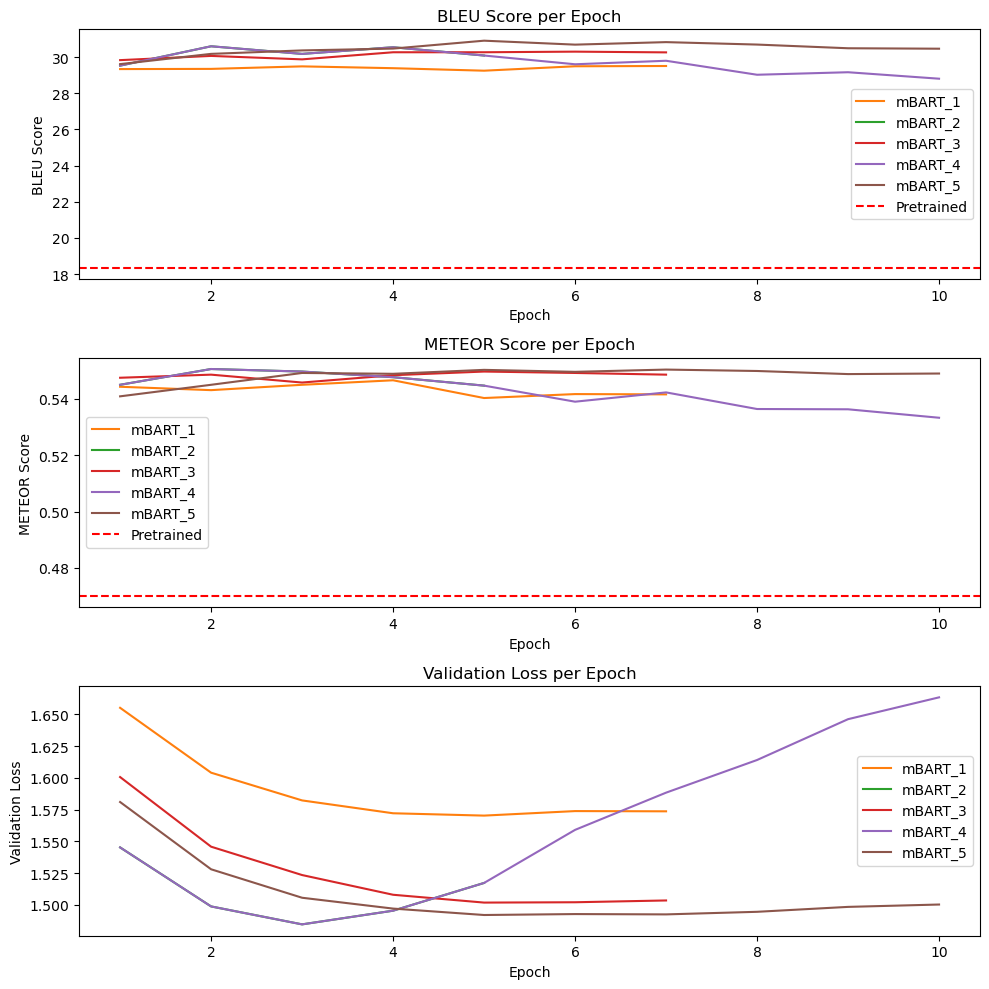

In [80]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
model_name = "mBART"
file_path = f"mtl_results/{model_name}.csv"
df = pd.read_csv(file_path)

# Adding a column for iteration based on the repeating epochs
df['Iteration'] = (df['Epoch'] == 1).cumsum()

# Define threshold values for BLEU, METEOR, and validation loss
bleu_pretrained = 18.35  # Example threshold for BLEU score
meteor_pretrained = 0.47  # Example threshold for METEOR score

# Create a figure with 3 subplots
fig, ax = plt.subplots(3, 1, figsize=(10, 10))

# Colors for each iteration
colors = plt.cm.tab10.colors

# Plotting BLEU scores
for iteration, data in df.groupby('Iteration'):
    ax[0].plot(data['Epoch'], data['BLEU'], label=f'{model_name}_{iteration}', color=colors[iteration % len(colors)])
ax[0].axhline(y=bleu_pretrained, color='r', linestyle='--', label='Pretrained')
ax[0].set_title('BLEU Score per Epoch')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('BLEU Score')
ax[0].legend()

# Plotting METEOR scores
for iteration, data in df.groupby('Iteration'):
    ax[1].plot(data['Epoch'], data['METEOR'], label=f'{model_name}_{iteration}', color=colors[iteration % len(colors)])
ax[1].axhline(y=meteor_pretrained, color='r', linestyle='--', label='Pretrained')
ax[1].set_title('METEOR Score per Epoch')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('METEOR Score')
ax[1].legend()

# Plotting Validation Loss
for iteration, data in df.groupby('Iteration'):
    ax[2].plot(data['Epoch'], data['validation_loss'], label=f'{model_name}_{iteration}', color=colors[iteration % len(colors)])
ax[2].set_title('Validation Loss per Epoch')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Validation Loss')
ax[2].legend()

# Adjust layout
plt.tight_layout()
plt.show()

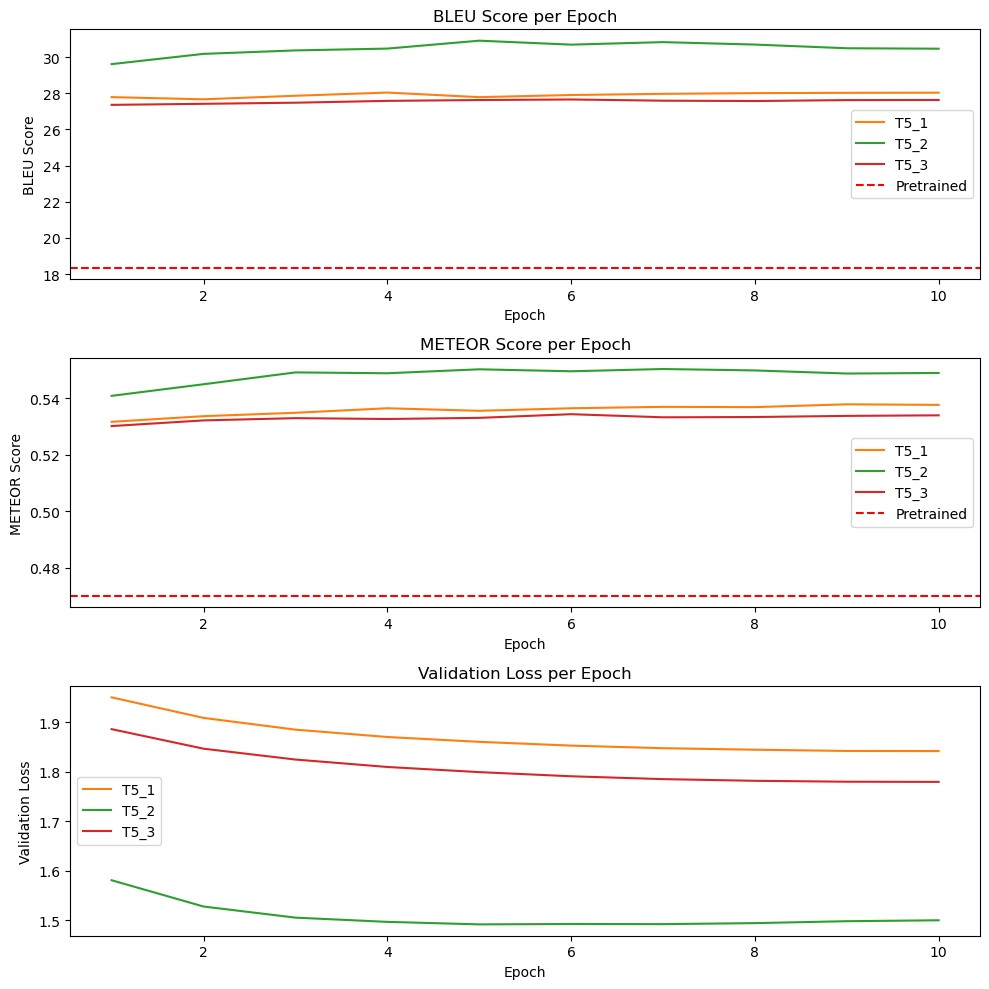

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
model_name = "T5"
file_path = f"mtl_results/{model_name}.csv"
df = pd.read_csv(file_path)

# Adding a column for iteration based on the repeating epochs
df['Iteration'] = (df['Epoch'] == 1).cumsum()

# Define threshold values for BLEU, METEOR, and validation loss
bleu_pretrained = 18.35  # Example threshold for BLEU score
meteor_pretrained = 0.47  # Example threshold for METEOR score

# Create a figure with 3 subplots
fig, ax = plt.subplots(3, 1, figsize=(10, 10))

# Colors for each iteration
colors = plt.cm.tab10.colors

# Plotting BLEU scores
for iteration, data in df.groupby('Iteration'):
    ax[0].plot(data['Epoch'], data['BLEU'], label=f'{model_name}_{iteration}', color=colors[iteration % len(colors)])
ax[0].axhline(y=bleu_pretrained, color='r', linestyle='--', label='Pretrained')
ax[0].set_title('BLEU Score per Epoch')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('BLEU Score')
ax[0].legend()

# Plotting METEOR scores
for iteration, data in df.groupby('Iteration'):
    ax[1].plot(data['Epoch'], data['METEOR'], label=f'{model_name}_{iteration}', color=colors[iteration % len(colors)])
ax[1].axhline(y=meteor_pretrained, color='r', linestyle='--', label='Pretrained')
ax[1].set_title('METEOR Score per Epoch')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('METEOR Score')
ax[1].legend()

# Plotting Validation Loss
for iteration, data in df.groupby('Iteration'):
    ax[2].plot(data['Epoch'], data['validation_loss'], label=f'{model_name}_{iteration}', color=colors[iteration % len(colors)])
ax[2].set_title('Validation Loss per Epoch')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Validation Loss')
ax[2].legend()

# Adjust layout
plt.tight_layout()
plt.show()
